This problem was done in cooperation between Aaron Maurer and Stanley Guan.

In [8]:
# Imports
import base64
import json
import numpy as np
from pyspark.mllib.clustering import KMeans
import matplotlib.pyplot as plt
from operator import itemgetter
%matplotlib inline

# Am I working on AWS?
AWS = False

# Check Spark is working
print sc 

In [11]:
# load data
if AWS:
    rawData = "s3n://stat-37601/digits.base64.json"
else:
    rawData = "data/digits.base64.json"

def parse(x):
   digit = json.loads(x)
   array = np.fromstring(base64.b64decode(digit["data"]),
     dtype = np.ubyte)
   return (digit["label"], array)

digits = sc.textFile(rawData).map(parse).cache()

####(a) Using the empirical risk criterion, determine which center is most closely associated with which label in the training set.

In [12]:
# initialize training and dev partitions
n = digits.count()
digits_train, digits_dev = digits.randomSplit([.75, .25], 100)
digits_train.cache()
digits_dev.cache()
print 'training and dev size: %d and %d.' % (digits_train.count(), digits_dev.count())

training and dev size: 44964 and 15036.


In [15]:
K = 10 # number of clusters
clusters = KMeans.train(digits_train.map(itemgetter(1)), K, maxIterations = 50, runs = 10, initializationMode = "random")

In [103]:
# helper function
def biggerValue(a,b):
    if a[1]>b[1]: return a
    else:         return b

# associate clusters with labels
# for each training digit find the center that is closest
# for each center, look at the distribution of labels that are associated with it
# choose the most frequently associated label for that center
def asscLabels(data,clusters):
    combDict = data.map(lambda x: ((clusters.predict(x[1]),x[0]),1)).countByKey()
    sortedList = sorted([(x[0][0],x[0][1],x[1]) for x in combDict.items()],key=lambda x: (x[0],x[2]),reverse=True)
    optLabelClust = [(sortedList[i][0],sortedList[i][1]) for i in range(len(sortedList)) if sortedList[i][0]!=sortedList[i-1][0] or i==1]
    return dict(optLabelClust)

In [104]:
clusterMatch = asscLabels(digits_train,clusters)

####(b) Print out the clusters and display the labels you inferred above, and compare them to the pictures.

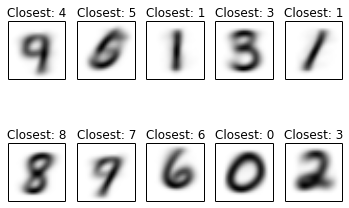

In [105]:
# visualize cluster centers and compare with closest label
f,subplts = plt.subplots(2,5)
for i in range(10):
    r = i/5
    c = i%5
    subplts[r,c].imshow(clusters.centers[i].reshape(28,28)).set_cmap('gray_r')
    subplts[r,c].axes.get_xaxis().set_visible(False)
    subplts[r,c].get_yaxis().set_visible(False)
    subplts[r,c].set_title('Closest: ' + str(clusterMatch[i]))

As you can see, these do pretty well, but a few seem to be half way inbetween two digits. For instance, the first cluster seems to be a combination of 4 and 9, while the seventh is a mix of 7 and 9. Truthfully, a k-medians algorith with the L1 norm might work a lot better.

#### (c) Compute the error rate of the clustering using the inferred labels on the development set.

In [19]:
def errorRate(data,clust,labels):
    return data.map(lambda x: labels[clust.predict(x[1])] != x[0]).mean()

In [162]:
ER = errorRate(digits_dev,clusters,clusterMatch)
print 'Error rate for %d clusters: %.2f%%' % (K, ER * 100)

Error rate for 10 clusters: 47.91%


####(d) Cluster the training set with variety of values of k, plot error, and find best k

In [ ]:
clustersK, clustersMatchK, ratesK = {},{},{}

In [121]:
# Compute test error for a range of K
# was going to do up to 1000, took too long
kVals = [int(x) for x in np.logspace(1,3,40) if int(x)<=554] 
for k in kVals:
    if not k in clustersK     : clustersK[k] = KMeans.train(digits_train.map(itemgetter(1)), k, maxIterations = 50, runs = 5, initializationMode = "random")
    if not k in clustersMatchK: clustersMatchK[k] = asscLabels(digits_train,clustersK[k])
    if not k in ratesK        : ratesK[k]=errorRate(digits_dev,clustersK[k],clustersMatchK[k])

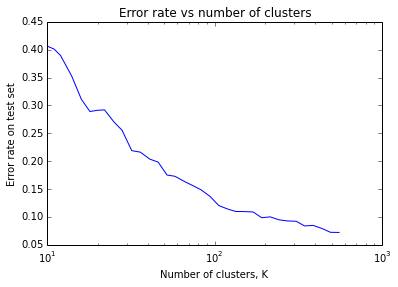

In [150]:
sortedRates = sorted(ratesK.items(),key=itemgetter(0))
plt.plot([x[0] for x in sortedRates],[x[1] for x in sortedRates],'-')
plt.xlabel('Number of clusters, K')
plt.ylabel('Error rate on test set')
plt.title('Error rate vs number of clusters')
plt.xscale('log')

We seem to keep getting marginal improvement as we add increase k. However, this does have to end at some point. If we set k to the number of observations, we are doing a 1-nearest neighbor classifier. Doing a quick test on just 100 observations, this is clearly inferior: 

In [52]:
# Calculate error rate of 1nn over 100 obervations
def findClosest(img):
    return digits_train.map(lambda x: (x[0], np.linalg.norm(x[1] - img[1],2), x[1])).min(itemgetter(1))

testsize = 100
test = digits_dev.take(testsize)
pred = [findClosest(x) for x in test]
correct = sum([test[i][0]==pred[i][0] for i in range(testsize)])
print 'Error rate for over %d observations for 1nn: %.2f%%' % (testsize,100-100*correct/float(testsize))

Error rate for over 100 observations for 1nn: 73.00%


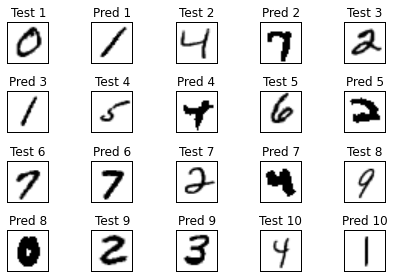

In [53]:
# Compare 10 test examples to nearest neighbor
f,subplts = plt.subplots(4,5)
f.tight_layout()
for i in range(10):
    rt = (2*i)/5
    ct = (2*i)%5
    subplts[rt,ct].imshow(test[i][1].reshape(28,28)).set_cmap('gray_r')
    subplts[rt,ct].axes.get_xaxis().set_visible(False)
    subplts[rt,ct].get_yaxis().set_visible(False)
    subplts[rt,ct].set_title('Test ' + str(i+1))

    rp = (1+2*i)/5
    cp = (1+2*i)%5
    subplts[rp,cp].imshow(pred[i][2].reshape(28,28)).set_cmap('gray_r')
    subplts[rp,cp].axes.get_xaxis().set_visible(False)
    subplts[rp,cp].get_yaxis().set_visible(False)
    subplts[rp,cp].set_title('Pred ' + str(i+1))


As you can see, this is far worse than any clustering with even a small number of clusters, so we can conclude the optimal number of clusters is high, but lower than the number of test examples. Part of the problem is that the 2-norm doesn't perform well for 1 nearest-neighbors on this data set; the 0-norm does a much better job without any nuance like rounding all the values to just black or white (I had an error rate around 15%).

#### (e) Supervised learning with clusters

In [151]:
# now find all clusters
cl = 20  # how many clusters per digit?
cls = [] # stores the 10 KMeans.train objects
for i in range(10):
    obj = KMeans.train(digits_train.filter(lambda x: x[0] == i).map(itemgetter(1)), cl, maxIterations = 50, runs = 5, initializationMode = "random")
    cls.append(obj)

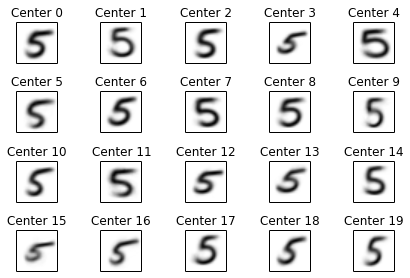

In [158]:
# Take a look at the cluster centers for 5
f,subplts = plt.subplots(cl//5,5)
f.tight_layout()
for i in range(cl):
    r = i/5
    c = i%5
    subplts[r,c].imshow(cls[5].centers[i].reshape(28,28)).set_cmap('gray_r')
    subplts[r,c].axes.get_xaxis().set_visible(False)
    subplts[r,c].get_yaxis().set_visible(False)
    subplts[r,c].set_title('Center ' + str(i))

In [161]:
# find error rate on test set
def isCorrect(x): # map job on test set
    mindist = float("inf")
    lab = -1
    for i in range(10): # for each label
        dist = np.linalg.norm(cls[i].centers[cls[i].predict(x[1])]-x[1],2)
        if dist < mindist:
            mindist = dist
            lab = i
    return x[0] == lab
print 'Error rate: %.2f%%' % ((1 - digits_dev.map(isCorrect).sum() / digits_dev.count()) * 100)

Error rate: 6.48%


This error rate is better than the best unsupervised error rate we saw, even with far fewer clusters total.